## Power analysis

We want to perform a test, in order to determine the number of sample we would need to a power of 80% on our test with an $\alpha$ of $0.5$. Our issue comes in when we determine the effect size. Most online sources we could find all rely on a prior data set for which we compute the within and total sums of squares. This effect size is a value between 0 and 1, but is generally skewed to lower values, where 0.15 is considered a large effect. We can not find a way to scale our differences in expectation and variances between the different queues to a meaningful effect size measure. 

I've provided the code we use for this in the cell below. The [Documentation](https://www.statsmodels.org/dev/_modules/statsmodels/stats/power.html#FTestAnovaPower) for the package

In [59]:
import statsmodels.stats.power as smp
for i in range(1, 10):
    x = i * 0.1
    sample_size = smp.FTestAnovaPower().solve_power(effect_size=x, alpha=0.01, k_groups=3, power=0.8, nobs=None)
    print("Effect size: %.2f, Sample size: %.2f" % (x, sample_size))


Effect size: 0.10, Sample size: 1392.68
Effect size: 0.20, Sample size: 351.64
Effect size: 0.30, Sample size: 158.88
Effect size: 0.40, Sample size: 91.44
Effect size: 0.50, Sample size: 60.25
Effect size: 0.60, Sample size: 43.33
Effect size: 0.70, Sample size: 33.15
Effect size: 0.80, Sample size: 26.56
Effect size: 0.90, Sample size: 22.06


As you can see the effect size has strong implications on the sample size. Therefore getting a good estimate is very important. We hope you can help us find a way to get an effect size estimate without generating a toy data set. 

Power:
- rho -> effect size
    - can't get analytical solutions for mmnP and mdn
- Distribution, what do they expect us to use, do we justify which distriubtions we use
- Analysis, is our current design valid
- Can we chose arbitrary rho, since we have to pick a point on which to compare the distributions of the expectation

# Using the Central Limit Theorem to transform random means


In [60]:
import plotly.express as px 
import numpy as np
import scipy.stats as stats
import statsmodels.stats.power as smp

In [61]:
mu1, sigma1 = 3, 2
mu2, sigma2 = 5, 4
mu3, sigma3 = 8, 3

# plotting initial probability density functions
x = np.linspace(-5, 15, 1000)
y1 = stats.norm.pdf(x, mu1, sigma1)
y2 = stats.norm.pdf(x, mu2, sigma2)
y3 = stats.norm.pdf(x, mu3, sigma3)

fig = px.line(title='Unscaled Normal Distributions')
fig.add_scatter(x=x, y=y1, name='Normal Distribution 1')
fig.add_scatter(x=x, y=y2, mode='lines', name='Normal Distribution 2')
fig.add_scatter(x=x, y=y3, mode='lines', name='Normal Distribution 3')
fig.show()

We now rescale the distributions such that the first distribution has mean 0 and variance 1, and use the same transformation on the other distributions

In [62]:
transformed_mu1, transformed_sigma1 = 0, 1
transformed_mu2, transformed_sigma2 = (mu2-mu1)/sigma1, sigma2/sigma1
transformed_mu3, transformed_sigma3 = (mu3-mu1)/sigma1, sigma3/sigma1

x = np.linspace(-5, 15, 1000)
y1 = stats.norm.pdf(x, transformed_mu1, transformed_sigma1)
y2 = stats.norm.pdf(x, transformed_mu2, transformed_sigma2)
y3 = stats.norm.pdf(x, transformed_mu3, transformed_sigma3)

fig = px.line(title='Unscaled Normal Distributions')
fig.add_scatter(x=x, y=y1, name='Standard Normal Distribution ')
fig.add_scatter(x=x, y=y2, mode='lines', name='Transformed Normal Distribution 2')
fig.add_scatter(x=x, y=y3, mode='lines', name='Transformed Normal Distribution 3')
fig.show()

Time to investigate some properties.
Firstly to the overlapping areas have the same probablity?

In [63]:
def integrate_overlap(mu1, sigma1, mu2, sigma2, start, end, step):
    x = np.arange(start, end, step)
    y1 = stats.norm.pdf(x, mu1, sigma1)
    y2 = stats.norm.pdf(x, mu2, sigma2)
    return np.trapz(np.minimum(y1, y2), x)

baseline12 = integrate_overlap(mu1, sigma1, mu2, sigma2, -10, 10, 0.001)
baseline13 = integrate_overlap(mu1, sigma1, mu3, sigma3, -10, 10, 0.001)

transformed12 = integrate_overlap(transformed_mu1, transformed_sigma1, transformed_mu2, transformed_sigma2, -10, 10, 0.001)
transformed13 = integrate_overlap(transformed_mu1, transformed_sigma1, transformed_mu3, transformed_sigma3, -10, 10, 0.001)

print(f"Baseline Overlap 1-2: {baseline12:.2f}")
print(f"Baseline Overlap 1-3: {baseline13:.2f}")
print(f"Transformed Overlap 1-2: {transformed12:.2f}")
print(f"Transformed Overlap 1-3: {transformed13:.2f}")

Baseline Overlap 1-2: 0.61
Baseline Overlap 1-3: 0.31
Transformed Overlap 1-2: 0.61
Transformed Overlap 1-3: 0.31


Now we investigate whether our power is unchanged

In [64]:
# assuming lambda = 1

mu = 1
def get_rhos(lam, mu):
    return lam / mu

def get_waiting_time(lam, mu, rho, n):
    if n == 1:
        return rho / (mu-lam)

    if n == 2:
        PI = 2 * rho**2 / (1+ rho)
        return PI / (n*mu-lam)
    else:
        PI = 32*rho**4 / (8*rho**3 + 12*rho**2 + 9*rho + 3)
        return PI / (n*mu-lam)
    
means = [[],[],[]]
rhos = []
for lam in np.arange(.9, 1.0, .01):
    rho = get_rhos(lam, mu)
    rhos.append(rho)
    for i,c in enumerate([1,2,4]):
        waiting_time = get_waiting_time(lam, mu, rho, c)
        means[i].append(waiting_time) 

fig = px.line(title='Waiting Time vs. Service Rate')
fig.add_scatter(x=rhos, y=means[0], name='1 Server')
fig.add_scatter(x=rhos, y=means[1], mode='lines', name='2 Servers')
fig.add_scatter(x=rhos, y=means[2], mode='lines', name='4 Servers')

fig.show()

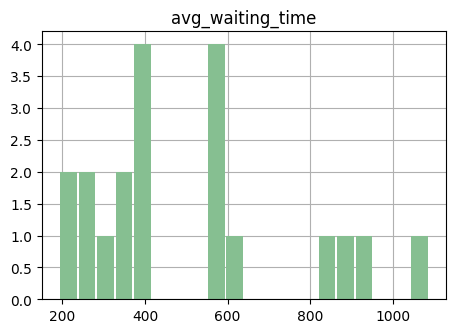

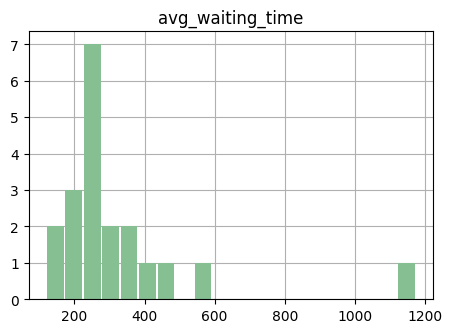

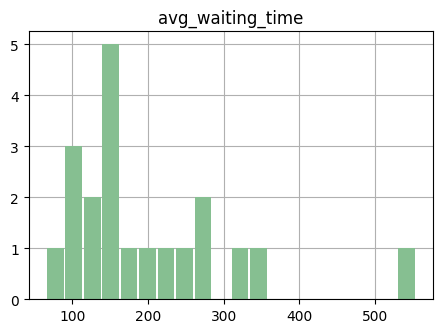

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

f = pd.read_csv('simulation_results/results.csv', header=0)
df = pd.DataFrame(f)
df = df.groupby('n_server')
# hist of average waiting time in one figure
df.hist(column='avg_waiting_time', bins=20, grid=True, figsize=(12,8), layout=(2,2), sharex=True, color='#86bf91', zorder=2, rwidth=0.9)
plt.show()


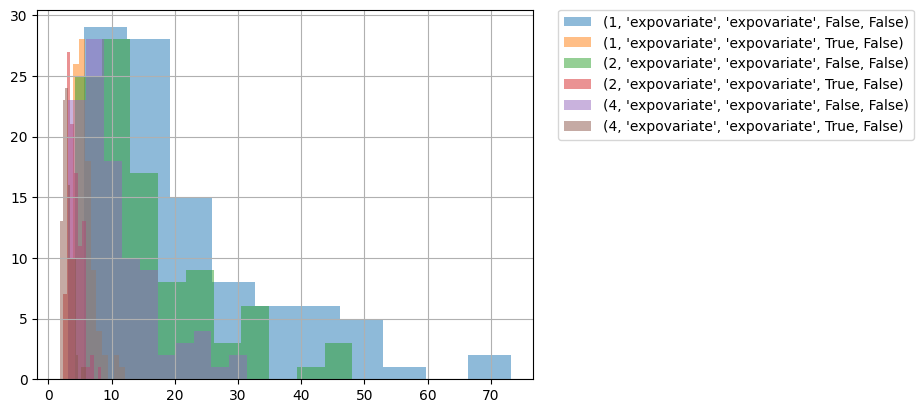

In [66]:
# Assuming 'waiting_time' is the column you want to plot
import matplotlib.pyplot as plt
for name, group in grouped:
    if np.mean(group['avg_waiting_time']) < 100:
        group['avg_waiting_time'].hist(alpha=0.5, label=str(name))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [116]:
import numpy as np
import random
def lognormal(x):
    '''Accepts the lambda from an exponential distribution and returns a lognormal distribution with the same mean and variance'''
    scaled_variance = np.log(1/x**2)

    scaled_mean = np.log(1/x) - scaled_variance / 2
    return np.random.lognormal(scaled_mean, np.sqrt(scaled_variance))

x = [lognormal(0.9) for i in range(100000)]
y = [random.expovariate(0.9) for i in range(100000)]

# variance and mean for each
print(f'Mean of lognormal: {np.mean(x)}')
print(f'Mean of exp: {np.mean(y)}')
print(f'Variance of x: {np.var(x)}')
print(f'Variance of y: {np.var(y)}')
print(f'Expected mean: {1/1/2}')
print(f'Variance: {1/(1/2**2)}')

# plotting the samples for lognormal and exponential
px.histogram(x, title='Lognormal Distribution')
# px.histogram(y, title='Exponential Distribution')


Mean of lognormal: 1.1115513597199778
Mean of exp: 1.109433660814939
Variance of x: 0.1368827261340988
Variance of y: 1.2282661290573769
Expected mean: 0.5
Variance: 4.0
